# Process Mooring 1123D, DWave 055025 using stglib

This workflow should work in an amazon workspace.

Version 2: includes configuration file setup to filling bad values and wave statistic calculations

Docs are here  https://stglib.readthedocs.io/en/latest/

## Prerequisites:

Make sure your local scripts are up to date with the github.  Use the notebook "Install the latest version of stglib", or use git clone in a terminal window.

Setup your data directories on pangeo, using the terminal (this is easier than using a notebook).  We like a heirarchy such as data/experiment/site/instrument/

Get your data into amazon workspace:  
- use ftp

Make a decision about CF or EPIC output.  Set up your global attribute file, or find it, for the deployment, use the notebook "Make global attribute file".  One global attribute file applies to all the instruments on a platform.

Make your atmospheric pressure compensation file with :dw_make_press_ac" notebook, put it in the same directory as your data.

Organize information you need to generate depth and water level relative to a datum.  This example makes use of:
- initial instrument height above the sea bed
- GPS-RTK measurements made at recovery
- offsets between instruments, determined from mooring log field notes

**Warning:**  This notebook will overwrite the .cdf and. nc files

## User information:

This is the information that will change for each instrument

Information relating to overall processing

In [1]:
data_directory = r'.'
global_attribute_file = r'../../glob_att1123D.txt'
instrument_configuration_file = '1123Ddw.yml'
processing_script_dir_win = r'D:\python\stglib\scripts'
processing_script_dir_pangeo = r'~/jovyan/code/stglib/scripts'
processing_script_to_cdf = 'runrskrsk2cdf.py'
processing_script_cdf_to_nc = 'runrskcdf2nc.py'
processing_script_nc_to_waves = 'runrsknc2waves.py'
mooring_number = '1123' # also found in the global attributes
mooring_subset_indicator = 'D' # used when a researcher prefers not to use a new mooring number when re-occupying the same site

Instrument configuration for an RBR D|wave, to construct the YAML (.yml) file used by stglib's scripts

In [2]:
instrument_config = {
    'basefile': 'Dwave_055025', # input file, usually .rsk
    'filename': mooring_number+mooring_subset_indicator+'dw', # name of output file, -raw.cdf or .nc will be appended
    'LatLonDatum': 'NAD83',
    'initial_instrument_height': 0.42,  # meters 
    'wp_max': 4,
    'wh_min': 0.02,
    'wp_ratio': 2,
    'P_1ac_note': 'Corrected for variations in atmospheric pressure using data from nearby met station (F0901 and D9542).'
}

Information relating to correction of Dwave measured pressure with local atmospheric pressure

In [3]:
met_data_directory = r'../../../met'  # it is practice to put all MET related data in a top level directory
atmospheric_pressure_csv_file = r'/combined_slp_all.csv'  # data downloaded from weather stations
atmospheric_pressure_nc_file = r'/combined_slp_all.nc'
atmospheric_pressure_cdf_this_mooring = 'atmpres.cdf' # gets saved in the local directory with the data
bp_variable_name = 'sea_level_pressure_set_1d' # expected in pascals
nominal_atmospheric_pressure = 10.1325 # decibars
# The trickiest part of this process is determining what to use as an offset. 
# recommendation is to run once with None, and examine the plot of atmospheric pressure
# prior to deployment.  Then you may wish to select the best representative pressure 
# at deployment time
# if None is designated here, the offset will be computed from the pressure measured prior to the deployment date
# or by hand, measurement prior to deployment - nominal atmospheric pressure
atmospheric_offset = 10.482-nominal_atmospheric_pressure # in decibars
print(f'atmospheric offset is {atmospheric_offset}')

atmospheric offset is 0.34949999999999903


Information relating to processing wave statistics

In [4]:
depth_cutoff = 0.25 # m of water needed, below this will be set to _FillValue in P_1ac
waveheight_cutoff = 0.05 # m of wave height that is a reasonable measurement to trust period calculations

Information relating to referencing the data to a NAVD88 datum

RTK-GPS RW5 file information from Sept., 2019

Point 6 plots up as the deeper spyder frame, based on this position `+41.926364734236,-70.068807461636` found in the file WLFT201909_latlon.txt

```
GPS,PN6,LA41.553491304325,LN-70.040770686189,EL-28.263559,--1123D3
--GS,PN6,N 4642152.9558,E 411381.3720,EL-0.8392,--1123D3
--GT,PN6,SW2071,ST395294400,EW2071,ET396241950
--Valid Readings: 897 of 900
--Fixed Readings: 897 of 900
--Nor Min: 4642152.9492  Max: 4642152.9645
--Eas Min: 411381.3679  Max: 411381.3758
--Elv Min: -0.8540  Max: -0.8270
--Nor Avg: 4642152.9558  SD: 0.0026
--Eas Avg: 411381.3720  SD: 0.0011
--Elv Avg: -0.8392  SD: 0.0047
--NRMS Avg: 0.0102 SD: 0.0025 Min: 0.0040 Max: 0.0240
--ERMS Avg: 0.0075 SD: 0.0018 Min: 0.0030 Max: 0.0170
--HSDV Avg: 0.0127 SD: 0.0030 Min: 0.0050 Max: 0.0294
--VSDV Avg: 0.0161 SD: 0.0038 Min: 0.0070 Max: 0.0370
--HDOP Avg: 0.4790  Min: 0.4000 Max: 0.5000
--VDOP Avg: 0.8000 Min: 0.8000 Max: 0.8000
--PDOP Avg: 0.9115 Min: 0.9000 Max: 1.0000
--Number of Satellites Avg: 17 Min: 16 Max: 18
--DT09-19-2019
--TM10:05:45
```

In [5]:
# RTK-GPS elevation was taken at the top of the altimeter
gps_rtk_elevation_measurement = -0.8392 # from 15 min average taken at deployment
gps_rtk_antenna_height = 0 # use 0 if included in the RTK-GPS reported elevation
# distance from bed to EA400 transducer
altimeter_initial_height = 0.37 # meters above the bed, measured at deployment
# it is altimeter_initial_height that is use in calculations below
# altimeter_final_height = 0.39 # meters above the bed, measured at recovery
altimeter_case_length = 0.26 # RTK-GPS point on top to the transducer
# dwave initial instrument height will be given in the global attributes

## Processing: ##

In [6]:
import os
import sys
import shutil
sys.path.append(r'D:\python\stglib')
import stglib
import seawater
import xarray as xr
import hvplot.xarray
import hvplot.pandas
import pandas as pd
import datetime as dt
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# clear out old data files helper function
def remove_old_files(file_path, file_list):
# check the data directory
    # I made this directory using the console before using this notebook
    files = os.listdir(file_path)

    for file in file_list:
        if file in files:
            print(f'{file} output file exists, removing')
            os.remove(file)


In [8]:
# helper function
# when data is open as netCDF4, can't use stglib's version, it is too specific to xarray
# so here is the equivalent for netCDF4 files
def add_min_max(ds_nc):
    # things we won't take min and max of
    exclude = list(ds_nc.dimensions.keys())
    [exclude.append(k) for k in ds.variables if 'time' in k]
    exclude.extend(['TIM','TransMatrix'])
    
    alloweddims = ['time', 'sample', 'depth']
    
    for varname in ds_nc.variables:
        if varname not in exclude:
            ds_nc[varname].minimum = np.nanmin(ds_nc[varname])
            ds_nc[varname].maximum = np.nanmax(ds_nc[varname])

    return ds_nc

In [10]:
# determine where we are running this stuff - a PC or pangeo
if 'jovyan' in os.getcwd():
    print('we are in pangeo')
    processing_script_dir = processing_script_dir_pangeo + r'/'
else:
    print('we are on a PC')
    #processing_script_dir = processing_script_dir_win + r'\\'
    # this worked on amazon, the above did not
    processing_script_dir = processing_script_dir_win
    
processing_script_to_cdf = processing_script_dir + processing_script_to_cdf
processing_script_cdf_to_nc = processing_script_dir + processing_script_cdf_to_nc
processing_script_nc_to_waves = processing_script_dir + processing_script_nc_to_waves

we are on a PC


In [11]:
# the global attribute data is useful, load it.
global_atts = stglib.read_globalatts(global_attribute_file)

In [12]:
# from global attributes, construct what will be the data file names (what the scripts will construct but we need here)
dwave_raw_cdf = global_atts['MOORING']+mooring_subset_indicator+'dw-raw.cdf'
dwave_nc = global_atts['MOORING']+mooring_subset_indicator+'dwb-cal.nc'
dwave_nc_filled = global_atts['MOORING']+mooring_subset_indicator+'dwb-cal-fill.nc'
dwave_wvs = global_atts['MOORING']+mooring_subset_indicator+'dws-a.nc'
dwave_wvs_filled = global_atts['MOORING']+mooring_subset_indicator+'dws-a-fill.nc'

In [13]:
os.chdir(data_directory)
%pwd

'D:\\data\\NRPP\\CACO\\1123\\1123D\\DWave_055025'

Make the instrument configuration (.yml) file using the information in the dict above.

In [14]:
ifile_name = global_atts['MOORING']+mooring_subset_indicator+'dw.yml'

with open(ifile_name,'w') as fp:
    for key in instrument_config.keys():
        print(f'    {key}: {instrument_config[key]}', file=fp)

In [15]:
# we need to check to see if the output data file exists and remove it, otherwise there will be a permission error
# this may fail if the file is open in say, ncbrowse, panoply, MATLAB or some other python process.
remove_old_files('.', [dwave_raw_cdf, dwave_nc, dwave_nc_filled, dwave_wvs])

**Converting the data:**

We want to run a script that is in the stglib package, and it is not on the path here in pangeo.  So we have obtained the scripts from github, here:  https://raw.githubusercontent.com/dnowacki-usgs/stglib/master/scripts/runrskrsk2cdf.py and cloned them locally into ~/code/stglib/scripts.  You may wish to check and make sure you have the latest each time you use this notebook.

Here's where the script is that will process the data:

In [16]:
processing_script_to_cdf

'D:\\python\\stglib\\scripts\\\\runrskrsk2cdf.py'

In [17]:
processing_script_to_cdf = 'D:\\python\\stglib\\scripts\\runrskrsk2cdf.py'

In [18]:
%run $processing_script_to_cdf $global_attribute_file $instrument_configuration_file

Loading from sqlite file Dwave_055025.rsk; this may take a while for large datasets
Done fetching pressure data
Writing to raw netCDF
Done


In [19]:
os.listdir(data_directory)

['!Process DWave 55025 on 1123D - start here.v4.ipynb',
 '!Process DWave 55025 on 1123D - start here.v5.ipynb',
 '.ipynb_checkpoints',
 '1123Ddw-raw.cdf',
 '1123Ddw.yml',
 'dwave55025.pdf',
 'Dwave_055025.rsk',
 'README.md']

**Check conversion results:**

In [20]:
ds_cdf = xr.open_dataset(dwave_raw_cdf)

In [21]:
ds_cdf

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 1, sample: 4096, time: 3071)
Coordinates:
  * time     (time) datetime64[ns] 2019-09-18T18:00:00 ... 2019-11-21T17:00:00
  * sample   (sample) int32 0 1 2 3 4 5 6 ... 4089 4090 4091 4092 4093 4094 4095
  * lat      (lat) float64 41.93
  * lon      (lon) float64 -70.07
Data variables:
    P_1      (time, sample) float64 ...
    burst    (time) int32 ...
Attributes:
    SciPi:                      N. Ganju
    PROJECT:                    USGS Coastal and Marine Geology Program
    EXPERIMENT:                 NRPP
    DESCRIPTION:                Wellfleet Herring River, Gut Flank Deep
    DATA_SUBTYPE:               MOORED
    DATA_ORIGIN:                USGS WHCMSC Sed Trans Group
    COORD_SYSTEM:               GEOGRAPHIC
    Conventions:                PMEL/EPIC
    MOORING:                    1123
    WATER_DEPTH:                0.23
    WATER_DEPTH_NOTE:           (meters), nominal depth
    latitude:                   41.926364734
    longitude:                  -70.068807462
    magnetic_variation:         -14.72
    Deployment_date:            2019-09-19 13:42:00
    Recovery_date:              2019-11-19 15:28:00
    DATA_CMNT:                  
    platform_type:              Spyder Frame
    DRIFTER:                    0.0
    POS_CONST:                  0.0
    DEPTH_CONST:                0.0
    WATER_MASS:                 Herring River, MA
    VAR_FILL:                   1e+35
    institution:                United States Geological Survey, Woods Hole C...
    institution_url:            https://woodshole.er.usgs.gov
    filename:                   1123Ddw
    LatLonDatum:                NAD83
    initial_instrument_height:  0.42
    wp_max:                     4
    wh_min:                     0.02
    wp_ratio:                   2
    P_1ac_note:                 Corrected for variations in atmospheric press...
    history:                    Processed using rsk2cdf.py with stglib 0.2.0+...
    samples_per_burst:          4096
    sample_interval:            0.25
    burst_interval:             1800.0
    burst_length:               1024.0
    serial_number:              55025
    INST_TYPE:                  RBR Virtuoso d|wave

In [22]:
ds_cdf['P_1'][:,0].hvplot()

:Curve   [time]   (P_1)

**Determine the pressure offset value:**

This is the difference between the mean atmospheric pressure measured at the site, just before the deployment, and nominal atmospheric pressure (which can be defined as a user setting)

In [23]:
p_air = ds_cdf['P_1'][ds_cdf['time'] < np.datetime64(global_atts['Deployment_date'])]
if atmospheric_offset is None:
    atmospheric_offset = p_air.mean().values - nominal_atmospheric_pressure
    print(f'mean pressure prior to deployment, using for offset = {atmospheric_offset}') 
else:
    print(f'atmospheric offset of {atmospheric_offset} set by user') 

atmospheric offset of 0.34949999999999903 set by user


In [24]:
p_air[:,0].hvplot()

:Curve   [time]   (P_1)

**Preparing atmospheric correction data:**

This is highly recommended for any data recorded at depths < 15 m

In [25]:
def read_met_data(filename):
    a = pd.read_csv(filename, header=7, parse_dates=[1],
                    infer_datetime_format=True, index_col=1)

    # add 6 hours to get to UTC (but remian naive)
    #a.index = a.index + pd.Timedelta('0 hours')
    a.index.rename('time', inplace=True)

    return xr.Dataset(a)

gndcrmet = read_met_data(met_data_directory + atmospheric_pressure_csv_file) # This creates an xarray Dataset
gndcrmet = gndcrmet[bp_variable_name].to_dataset() # Let's keep only the BP variable
gndcrmet['BP'] = gndcrmet[bp_variable_name]/100/100 # convert our atmos data (in pascals) to decibars
# gndcrmet['BP'] = gndcrmet['BP'] - atmospheric_offset
gndcrmet.to_netcdf(met_data_directory + atmospheric_pressure_nc_file) 

Generate the atmpres.cdf file:

This generates the file and embeds the instrument-specific offset as an attr. The trickiest part of this process is determining what to use as an offset. After you run this cell, you will have your very own atmpres.cdf file!

In [26]:
# Load the met data
gndcrmet = xr.open_dataset(met_data_directory + atmospheric_pressure_nc_file)

met = gndcrmet['BP'] # make a new met variable
met = met.rename('atmpres') # rename it to the standard atmpres variable name
met = met.reindex(time=ds_cdf['time'], copy=True, method='nearest') # reindex the met data onto the Aquadopp time base
met.attrs.update(offset=atmospheric_offset) # set the atmospheric offset as an attribute
met.to_netcdf(atmospheric_pressure_cdf_this_mooring) # save to disk

In [27]:
ds_met = xr.open_dataset(atmospheric_pressure_cdf_this_mooring, decode_times=True, use_cftime=True)

In [28]:
ds_met['atmpres'].hvplot()

:Curve   [time]   (atmpres)

**Convert raw cdf to publishable, including atmospheric pressure and other corrections and manipulations:**

In [29]:
# check our path
processing_script_cdf_to_nc

'D:\\python\\stglib\\scripts\\\\runrskcdf2nc.py'

In [30]:
# usage: runrskcdf2nc.py [-h] [--atmpres ATMPRES] cdfname
atmpres = '--atmpres '+atmospheric_pressure_cdf_this_mooring
%run $processing_script_cdf_to_nc  $atmpres $dwave_raw_cdf

first burst in full file: 2019-09-18T18:00:00.000000000, idx 0
last burst in full file: 2019-11-21T17:00:00.000000000, idx 3070
Clipping data using Deployment_date and Recovery_date
first burst in trimmed file: 2019-09-19T14:00:00.000000000
last burst in trimmed file: 2019-11-19T15:00:00.000000000
Atmospherically correcting data
Correcting using offset of 0.349500
about to create epic times
Creating 2D time variable
Creating depth dimension
Writing cleaned/trimmed data to .nc file
Done writing netCDF file 1123Ddwb-cal.nc


In [31]:
os.listdir(data_directory)

['!Process DWave 55025 on 1123D - start here.v4.ipynb',
 '!Process DWave 55025 on 1123D - start here.v5.ipynb',
 '.ipynb_checkpoints',
 '1123Ddw-raw.cdf',
 '1123Ddw.yml',
 '1123Ddwb-cal.nc',
 'atmpres.cdf',
 'dwave55025.pdf',
 'Dwave_055025.rsk',
 'README.md']

**Add depth and water level referenced to a datum**

In [32]:
# note that we cannot use xarray here as the data has time, time2 and sample
ds_nc = nc.Dataset(dwave_nc,'r+')

Depth converted from pressure using the CSIRO seawater package

In [33]:
depth = seawater.dpth(ds_nc['P_1ac'][:,:], ds_nc['lat'][0])

In [34]:
varobj = ds_nc.createVariable('D_3', 'float', ('time','sample'), fill_value=1E35)
varobj.setncattr('name', 'water depth')
varobj.long_name = 'Water depth computed from atmospheric corrected pressure'
varobj.units = 'm'
varobj.note = 'Corrected for variations in local atmospheric pressure using local barometric pressure record'
varobj.initial_instrument_height = ds_nc['P_1'].initial_instrument_height
varobj.height_depth_units = ds_nc['P_1'].height_depth_units
varobj.serial_number = ds_nc['P_1'].serial_number
varobj[:,:] = depth

Water level, referenced to a datum as follows:
- initial instrument height for the D|Wave is corrected by the GPS-RTK measurement of the elevation of the nearby altimeter 
- D|Wave port elevation above the sea bed = GPS-RTK elevation at the top of the altimeter - GPS-RTK antenna height - altimeter case length - altimeter initial height + D|Wave initial height
- water level = depth + RTK-GPS referenced D|Wave port elevation

In [35]:
dwave_elevation = gps_rtk_elevation_measurement - gps_rtk_antenna_height - altimeter_case_length - altimeter_initial_height + \
    ds_nc['P_1'].initial_instrument_height
wl = ds_nc['D_3'][:,:] + dwave_elevation

In [36]:
varobj = ds_nc.createVariable('WL_NAVD88', 'float', ('time','sample'), fill_value=1E35)
# note that mins and maxs will be updated later
varobj.setncattr('name', 'water level')
varobj.long_name = 'Sea surface elevation referenced to NAVD88 geodetic datum'
varobj.units = 'meters (NAVD88)'
varobj.note = 'Corrected for variations in local atmospheric pressure using local barometric pressure record'
varobj.initial_instrument_height = ds_nc['P_1'].initial_instrument_height
varobj.height_depth_units = ds_nc['P_1'].height_depth_units
varobj.serial_number = ds_nc['P_1'].serial_number
varobj.note = f'WL_NAVD88 = atmospheric corrected depth + {dwave_elevation} (sensor elevation, NAVD88)'
varobj[:,:] = wl

In [37]:
ds_nc.close()

**Check results:**

In [38]:
ds_nc = xr.open_dataset(dwave_nc, drop_variables={'time','time2'}, decode_times=False)

In [39]:
ds_nc

<xarray.Dataset>
Dimensions:     (depth: 1, lat: 1, lon: 1, sample: 4096, time: 2931)
Coordinates:
  * sample      (sample) int32 0 1 2 3 4 5 6 ... 4090 4091 4092 4093 4094 4095
  * lat         (lat) float64 41.93
  * lon         (lon) float64 -70.07
  * depth       (depth) float64 1.109
Dimensions without coordinates: time
Data variables:
    time_cf     (time) int32 ...
    P_1         (time, sample) float32 ...
    burst       (time) float32 ...
    P_1ac       (time, sample) float32 ...
    epic_time   (time) int32 ...
    epic_time2  (time) int32 ...
    D_3         (time, sample) float64 ...
    WL_NAVD88   (time, sample) float64 ...
Attributes:
    SciPi:                      N. Ganju
    PROJECT:                    USGS Coastal and Marine Geology Program
    EXPERIMENT:                 NRPP
    DESCRIPTION:                Wellfleet Herring River, Gut Flank Deep
    DATA_SUBTYPE:               MOORED
    DATA_ORIGIN:                USGS WHCMSC Sed Trans Group
    COORD_SYSTEM:               GEOGRAPHIC + sample
    Conventions:                PMEL/EPIC
    MOORING:                    1123
    WATER_DEPTH:                0.23
    WATER_DEPTH_NOTE:           (meters), nominal depth
    latitude:                   41.926364734
    longitude:                  -70.068807462
    magnetic_variation:         -14.72
    Deployment_date:            2019-09-19 13:42:00
    Recovery_date:              2019-11-19 15:28:00
    DATA_CMNT:                  
    platform_type:              Spyder Frame
    DRIFTER:                    0.0
    POS_CONST:                  0.0
    DEPTH_CONST:                0.0
    WATER_MASS:                 Herring River, MA
    VAR_FILL:                   1e+35
    institution:                United States Geological Survey, Woods Hole C...
    institution_url:            https://woodshole.er.usgs.gov
    filename:                   1123Ddw
    LatLonDatum:                NAD83
    initial_instrument_height:  0.42
    wp_max:                     4
    wh_min:                     0.02
    wp_ratio:                   2
    P_1ac_note:                 Corrected for variations in atmospheric press...
    history:                    Processed to EPIC using runrskcdf2nc.py. Data...
    samples_per_burst:          4096
    sample_interval:            0.25
    burst_interval:             1800.0
    burst_length:               1024.0
    serial_number:              55025
    INST_TYPE:                  RBR Virtuoso d|wave
    nominal_instrument_depth:   -0.18999999999999997
    COMPOSITE:                  0
    start_time:                 2019-09-19T14:00:00.000000000
    stop_time:                  2019-11-19T15:00:00.000000000
    DELTA_T:                    1800

In [40]:
print(type(ds_met['time']))

<class 'xarray.core.dataarray.DataArray'>


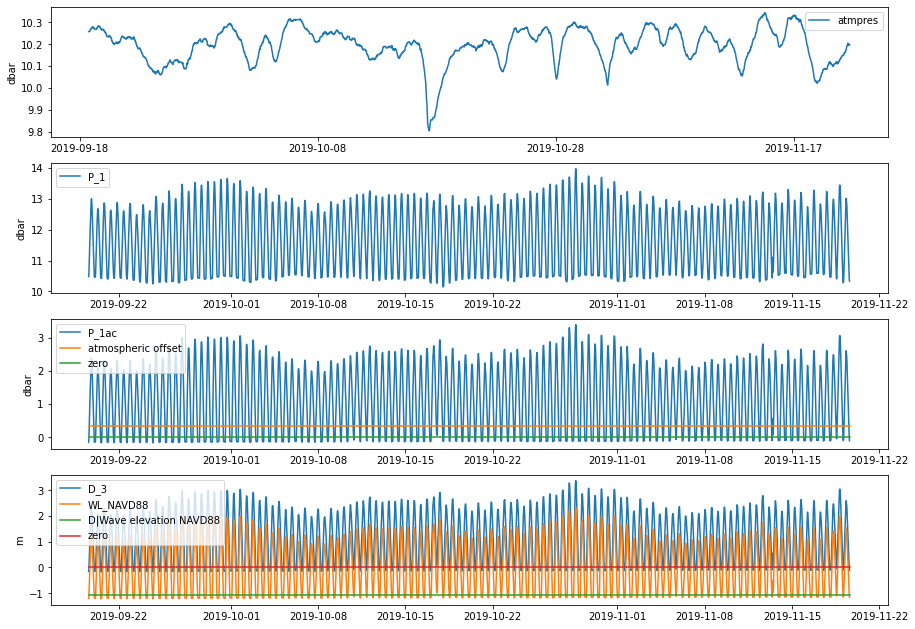

In [41]:
t = stglib.utils.epic_to_datetime(ds_nc['epic_time'][:].values,ds_nc['epic_time2'][:].values)
fig, ax = plt.subplots(4,1,figsize=(15,11))
#ax[0].plot(t,diff, label='P_1-P_1ac')
pnum = 0
ax[pnum].plot(ds_met['time'],ds_met['atmpres'], label='atmpres')
ax[pnum].set_ylabel(ds_nc['P_1ac'].units)
ax[pnum].legend()
pnum += 1
ax[pnum].plot(t,ds_nc['P_1'][:,0].values, label='P_1')
ax[pnum].set_ylabel(ds_nc['P_1'].units)
ax[pnum].legend()
pnum += 1
ax[pnum].plot(t,ds_nc['P_1ac'][:,0].values, label='P_1ac')
ax[pnum].plot([t[0],t[-1]],[atmospheric_offset, atmospheric_offset], label='atmospheric offset')
ax[pnum].plot([t[0],t[-1]],[0, 0], label='zero')
ax[pnum].set_ylabel(ds_nc['P_1ac'].units)
ax[pnum].legend()
pnum += 1
ax[pnum].plot(t,ds_nc['D_3'][:,0].values, label='D_3')
ax[pnum].plot(t,ds_nc['WL_NAVD88'][:,0].values, label='WL_NAVD88')
ax[pnum].plot([t[0],t[-1]],[dwave_elevation, dwave_elevation], label='D|Wave elevation NAVD88')
ax[pnum].plot([t[0],t[-1]],[0, 0], label='zero')
ax[pnum].set_ylabel(ds_nc['D_3'].units)
ax[pnum].legend()

In [42]:
ds_cdf.close()
ds_nc.close()
ds_met.close()

**Tidy up:**

Fix up some things post processing

In [43]:
# these are appropriate for the wave statistics, and not the pressure time series, so remove them
attributes_to_remove = {'wp_max','wh_min','wp_ratio'}
ds_nc = nc.Dataset(dwave_nc,'r+')

for attr in attributes_to_remove:
    try:
        ds_nc.delncattr(attr)
    except:
        pass
    
convention = ds_nc.Conventions
    
ds_nc.close()

If we are creating files with CF conventions, make a separate copy.  Wave processing will not work downstream.  This will cause a kernel restart.

In [44]:
if 'CF' in convention:
    print('CF conventions detected.  Making a CF-tagged copy of files.')
    shutil.copyfile(dwave_raw_cdf, global_atts['MOORING']+mooring_subset_indicator+'dw-rawCF.cdf')
    shutil.copyfile(dwave_nc, global_atts['MOORING']+mooring_subset_indicator+'dwb-calCF.nc')
    quit #raise SystemExit("Stop right there!")
else:
    print('data is in EPIC conventions')

data is in EPIC conventions


## Apply fill values: ##

We want to only compute wave statisics when the water has been deep enough.

In [45]:
# make a new copy
shutil.copyfile(dwave_nc, dwave_nc_filled)
ds_nc = nc.Dataset(dwave_nc_filled,'r+')
# variable to fill
varname = 'P_1ac'
fill = ds_nc[varname]._FillValue
# put only the data we're operating on in a pandas dataframe
pds = pd.DataFrame(data=ds_nc[varname][:,:], index=ds['burst'][:], columns=ds['sample'][:])
# replace the data of interest
pdsfilled = pds.where(pds > depth_cutoff, other=fill)
# insert back into the netCDF file
ds_nc[varname][:,:] = pdsfilled.values
# update min and max
ds_nc = add_min_max(ds_nc)
# update the history
hist = ds_nc.history + f'; {varname} set to _FillValue where < {depth_cutoff} m'
ds_nc.history = hist
ds_nc.close()

## Calculate wave statistics: ##

In [46]:
print(processing_script_nc_to_waves)

D:\python\stglib\scripts\\runrsknc2waves.py


In [47]:
# there will be some warnings here that seem to be harmless
%run $processing_script_nc_to_waves  $dwave_nc_filled

Computing waves statistics


D:\Users\mmartini\Miniconda3\envs\favs\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
D:\python\stglib\stglib\core\waves.py:287: RuntimeWarning: invalid value encountered in less
  y = np.sqrt(x) * (x < 1) + x * (x >= 1)
D:\python\stglib\stglib\core\waves.py:287: RuntimeWarning: invalid value encountered in greater_equal
  y = np.sqrt(x) * (x < 1) + x * (x >= 1)
D:\python\stglib\stglib\core\waves.py:290: RuntimeWarning: invalid value encountered in true_divide
  y = y - ((y*t-x) / (t + y * (1-t**2)))
D:\python\stglib\stglib\core\waves.py:163: RuntimeWarning: invalid value encountered in greater
  tmp = np.where(Pxx > noisecut)[0]


<Figure size 432x288 with 0 Axes>

In [48]:
ds_wvs = xr.open_dataset(dwave_wvs, decode_times=False)

In [49]:
ds_wvs

<xarray.Dataset>
Dimensions:      (depth: 1, frequency: 129, lat: 1, lon: 1, sample: 4096, time: 2931)
Coordinates:
    time_cf      (time) int32 ...
  * lat          (lat) float64 41.93
  * lon          (lon) float64 -70.07
  * depth        (depth) float64 1.109
  * time         (time) int32 2458746 2458746 2458746 ... 2458807 2458807
    time2        (time) int32 ...
  * frequency    (frequency) float64 0.0 0.01562 0.03125 ... 1.969 1.984 2.0
Dimensions without coordinates: sample
Data variables:
    burst        (time) float32 ...
    D_3          (time, sample) float32 ...
    WL_NAVD88    (time, sample) float32 ...
    wp_peak      (time, lat, lon) float32 ...
    wh_4061      (time, lat, lon) float32 ...
    wp_4060      (time, lat, lon) float32 ...
    pspec        (time, frequency, lat, lon) float32 ...
    water_depth  (time, lat, lon) float32 ...
Attributes:
    SciPi:                      N. Ganju
    PROJECT:                    USGS Coastal and Marine Geology Program
    EXPERIMENT:                 NRPP
    DESCRIPTION:                Wellfleet Herring River, Gut Flank Deep
    DATA_SUBTYPE:               MOORED
    DATA_ORIGIN:                USGS WHCMSC Sed Trans Group
    COORD_SYSTEM:               GEOGRAPHIC + sample
    Conventions:                PMEL/EPIC
    MOORING:                    1123
    WATER_DEPTH:                0.23
    WATER_DEPTH_NOTE:           (meters), nominal depth
    latitude:                   41.926364734
    longitude:                  -70.068807462
    magnetic_variation:         -14.72
    Deployment_date:            2019-09-19 13:42:00
    Recovery_date:              2019-11-19 15:28:00
    DATA_CMNT:                  
    platform_type:              Spyder Frame
    DRIFTER:                    0.0
    POS_CONST:                  0.0
    DEPTH_CONST:                0.0
    WATER_MASS:                 Herring River, MA
    VAR_FILL:                   1e+35
    institution:                United States Geological Survey, Woods Hole C...
    institution_url:            https://woodshole.er.usgs.gov
    filename:                   1123Ddw
    LatLonDatum:                NAD83
    initial_instrument_height:  0.42
    P_1ac_note:                 Corrected for variations in atmospheric press...
    history:                    Processed to EPIC using runrskcdf2nc.py. Data...
    samples_per_burst:          4096
    sample_interval:            0.25
    burst_interval:             1800.0
    burst_length:               1024.0
    serial_number:              55025
    INST_TYPE:                  RBR Virtuoso d|wave
    nominal_instrument_depth:   -0.18999999999999997
    COMPOSITE:                  0
    start_time:                 2019-09-19T14:00:00.000000000
    stop_time:                  2019-11-19T15:00:00.000000000
    DELTA_T:                    1800

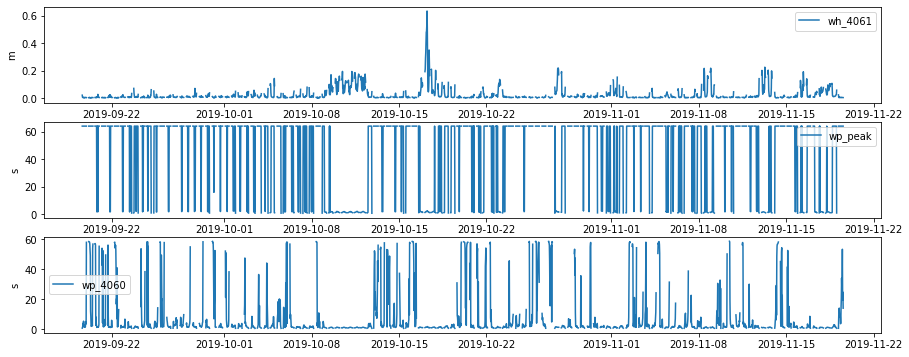

In [50]:
t = stglib.utils.epic_to_datetime(ds_wvs['time'][:].values,ds_wvs['time2'][:].values)
vars_to_plot = ['wh_4061', 'wp_peak', 'wp_4060']

fig, ax = plt.subplots(len(vars_to_plot),1,figsize=(15,len(vars_to_plot)*2))
for item in enumerate(vars_to_plot):
    ax[item[0]].plot(t,ds_wvs[item[1]][:,0,0], label=item[1])
    ax[item[0]].set_ylabel(ds_wvs[item[1]].units)
    ax[item[0]].legend()

In [51]:
ds_wvs.close()

We only want to save period statistics where wave height greater than a certain value

In [52]:
# make a new copy
shutil.copyfile(dwave_wvs, dwave_wvs_filled)
ds = nc.Dataset(dwave_wvs_filled,'r+')

In [53]:
ds.variables.keys()

odict_keys(['time_cf', 'burst', 'lat', 'lon', 'depth', 'D_3', 'WL_NAVD88', 'time', 'time2', 'wp_peak', 'wh_4061', 'wp_4060', 'frequency', 'pspec', 'water_depth'])

In [54]:
# the first variable is the variable to use as the evaluation to find the indeces we will fill
varnames = ['wh_4061', 'wp_peak', 'wp_4060','water_depth']

First, we need to fill values where there isn't enough wave height to determine a resonable period.

In [55]:
data = ds[varnames[0]][:,0,0] # np array
idx = np.where(data < waveheight_cutoff)

data_filled = {}

for varname in varnames[0:]:
    fill = ds[varname]._FillValue
    data = ds[varname][:,0,0]
    data[idx] = fill
    data_filled[varname] = data

Text(0.5, 1.0, 'waveheight cutoff = 0.05')

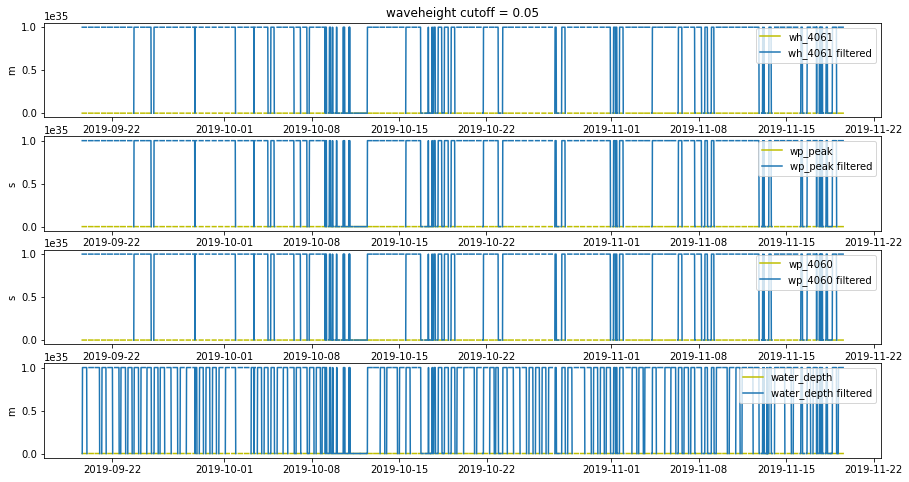

In [56]:
t = stglib.utils.epic_to_datetime(ds['time'][:],ds['time2'][:])
vars_to_plot = varnames

fig, ax = plt.subplots(len(vars_to_plot),1,figsize=(15,len(vars_to_plot)*2))
for item in enumerate(vars_to_plot):
    ax[item[0]].plot(t,ds[item[1]][:,0,0], label=item[1], color='y')
    ax[item[0]].plot(t,data_filled[item[1]], label=f'{item[1]} filtered')
    ax[item[0]].set_ylabel(ds[item[1]].units)
    ax[item[0]].legend()
    
ax[0].set_title(f'waveheight cutoff = {waveheight_cutoff}')

In [57]:
# insert back into the netCDF file
varnames = ['wh_4061', 'wp_peak', 'wp_4060']

for varname in varnames:
    ds[varname][:,:] = data_filled[varname]
    

In [58]:
ds = add_min_max(ds)

Update the file's history

In [59]:
hist = ds.history+f'; wave statistics set to _FillValue for times when wh_4061 < {waveheight_cutoff}' 
print(hist)

Processed to EPIC using runrskcdf2nc.py. Data clipped using Deployment_date of 2019-09-19 13:42:00 and Recovery_date of 2019-11-19 15:28:00. Processed using rsk2cdf.py with stglib 0.2.0+8.g70ab4be, xarray 0.15.1, NumPy 1.18.4, netCDF4 1.5.1.2, Python 3.7.6. ; P_1ac set to _FillValue where < 0.25 m; wave statistics set to _FillValue for times when wh_4061 < 0.05


In [60]:
ds.history = hist

In [61]:
ds.close()

**Finishing steps:**

Download your data from jupyter-lab, or put your finished files back up on FTP, using the notebook "Get data out of pangeo" or in S3 bucket.